# Mariana Maroto Assignment 2
## Gradient Descent from Scratch

### Part A. Model Code

#### 1. Function that generates the polynomial and interaction features for a given degree of the polynomial. 

In [1]:
import numpy as np
import pandas as pd

def polynomialFeatures(X, degree = 1):
    
    def pol_features(row, degree):
        if degree == 1:
            result = row
            return result # if degree one then keep the same row
        elif degree > 1:
            new_result = []
            result = pol_features(row, degree-1) # iterate over every degree ... 
            new_result.extend(result)
            for item in row:
                for p_item in result:
                    res = item * p_item
                    new_result.append(res)
            return new_result
    
    l = [] # create a list to store transformed rows
    for row in X:
        l.append(pol_features(row.tolist(), degree))
    return np.asarray(l) # return in numpy form 
       
# check if it works
example_array = np.array([[2, 5], 
                      [1, 2], 
                      [0, 3]]) 

print(polynomialFeatures(example_array, 2))

[[ 2  5  4 10 10 25]
 [ 1  2  1  2  2  4]
 [ 0  3  0  0  0  9]]


#### 2. Function to calculate and return the mean squared error (mse) of two vectors. 

In [2]:
def mse(Y_true, Y_pred):
    cost = 0  
    for i in range (0,len(Y_true)):  
      squared_dif = (Y_true[i] - Y_pred[i])**2 # difference between Y_true and Y_pred
      cost = cost + squared_dif
    MSE = cost/len(Y_true) # averaging
    return MSE

# check if it works
a = [1,2,3]
b = [1.2,2.1,3.3]

print(mse(a,b))

0.046666666666666634


#### 3. Learning Curve Function

In [3]:
import random
import matplotlib.pyplot as plt 

def rmse(Y_true, Y_pred):
    cost = 0  
    for i in range (0,len(Y_true)):  
        squared_dif = (Y_true[i] - Y_pred[i])**2 # difference between Y_true and Y_pred
        cost = cost + squared_dif
    RMSE = (cost/len(Y_true))**(0.5) # averaging
    return RMSE

def sFold_lc(folds, data, labels, model, *model_args, error_function): 
    
    all_data = np.c_[data, labels]
    # i. helper function which creates data_splits
    data_splits = list()
    data_copy = list(all_data)
    fold_size = int(len(data_copy) / folds)
    
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(data_copy))
            fold.append(data_copy.pop(index))
        data_splits.append(fold)

    # ii. for each partition, make model, remove one fold, make prediction, store prediction
    model = model
    val_scores = list()
    train_scores = list()
    expected = list()
    predicted = list()
    
    for ds in data_splits:
        train_set = list(data_splits)
        train_set = [ x for x in train_set if not (x==np.array(ds)).all()]
        train_set = sum(train_set,[])
        test_set = list()
        for row in ds:
            row_copy = list(row)
            test_set.append(row_copy)
        
        y_train = [row[-1] for row in train_set]
        train_set = np.asarray([train[:-1] for train in train_set])
        
        model.fit(X = train_set, Y = y_train)
        
        actual = [row[-1] for row in test_set]
        test_set = np.asarray([test[:-1] for test in test_set])
        
        # Make Validation prediction in current partition
        estimate_val  = model.predict(test_set, *model_args)
        acc_val = error_function(actual, estimate_val)
        
        # Make Train prediction in current partition
        estimate_train  = model.predict(train_set, *model_args)
        acc_train = error_function(y_train, estimate_train)
        
        val_scores.append(acc_val)
        train_scores.append(acc_train)
        
    val_average_scores = sum(val_scores)/len(val_scores)
    train_average_scores = sum(train_scores)/len(train_scores)
    final_dict = {'average valid error' : val_average_scores, 'average train error' : train_average_scores}
    
    return final_dict

def learning_curve(model, X, Y, cv, train_sizes=[10,100,500,100,2000,3000]):
    if all(isinstance(item, float) for item in train_sizes):
        train_sizes = [i * (len(Y)) for i in train_sizes]
    train_mean = []
    val_mean = []
    training_size = []
    for i in train_sizes:
        X_selected = X[:i,:]
        Y_selected = Y[:i]
        evaluate = sFold_lc(folds = cv, data = X_selected, labels = Y_selected, 
                        model = model, error_function = rmse)
        train_mean.append(evaluate['average train error'])
        val_mean.append(evaluate['average valid error'])
        training_size.append(i)
        
    # Visualization        
    plt.plot(training_size, train_mean, "r-+", linewidth=3, label="Training Score")
    plt.plot(training_size, val_mean, "b-", linewidth=2, label="Cross-validation Score")
    plt.title('Learning Curve')     
    plt.xlabel('Training Set Size')     
    plt.ylabel('RMSE')
    plt.legend(loc="best", fontsize=14)   
    plt.show() 

#### 5. Linear Regression Model Class

In [4]:
#Linear Regression

class Linear_Regression():
    
    def __init__(self, learning_rate =0.01, epochs = 1000, regularizer = 'l1', tol = None, lamb = 0.0, **kwargs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lamb = lamb
        
    def fit(self, X, Y, *kwargs): 
        self.X = X
        self.Y = Y  
        self.kwargs = kwargs       
        self.m, self.n = X.shape # of traning samples and features
        
        #Initialize 
        self.W = np.zeros(self.n)
        self.b = 0
        
        # gradient descent learning if given epochs     
        if self.tol == None:
            for i in range(self.epochs):
                if self.regularizer == 'l1':
                    self.lasso_update_weights()   
                elif self.regularizer == 'l2':
                    self.ridge_update_weights()
                else:
                    self.update_weights()
            return self
        # gradient descent learning if given tol
        if isinstance(self.tol,float):
            error = 1
            previous_error = 0
            while error > previous_error - self.tol:
                if self.regularizer == 'l1':
                    self.lasso_update_weights()   
                elif self.regularizer == 'l2':
                    self.ridge_update_weights()
                else:
                    self.update_weights()
                previous_error = error
                error = self.b
            return self                
    
    # without any regularizer
    def update_weights(self) :   
        Y_pred = self.predict(self.X) 
        # calculate gradients   
        dW = - (2*(self.X.T).dot(self.Y - Y_pred))/self.m 
        db = - 2*np.sum(self.Y - Y_pred)/self.m  
        # update weights 
        self.W = self.W - self.learning_rate*dW 
        self.b = self.b - self.learning_rate*db
        return self
    
    # helper function for Ridge Regression  or L2
    def ridge_update_weights(self):            
        Y_pred = self.predict(self.X) 
        # calculate gradients       
        dW = (-(2*(self.X.T).dot(self.Y- Y_pred)) + ((2 * self.lamb * self.W))/self.m)    
        db = -2*np.sum(self.Y - Y_pred)/self.m  
        # update weights     
        self.W = self.W - self.learning_rate*dW     
        self.b = self.b - self.learning_rate*db         
        return self

    # helper function for Lasso Regression  or L1
    def lasso_update_weights(self) :     
        Y_pred = self.predict(self.X) 
        # calculate gradients   
        dW = np.zeros(self.n) 
        for j in range(self.n):   
            if self.W[j] > 0:    
                dW[j] = (-(2*(self.X[:, j]).dot(self.Y - Y_pred)) + self.lamb)/self.m 
            else : 
                dW[j] = (-(2*(self.X[:, j]).dot(self.Y - Y_pred)) - self.lamb)/self.m 
        db = - 2*np.sum(self.Y - Y_pred)/self.m 
        # update weights 
        self.W = self.W - self.learning_rate*dW 
        self.b = self.b - self.learning_rate*db 
        return self
    
    def predict(self, X):
        return X.dot(self.W) + self.b 


#### 6. Read Dataset

In [5]:
import pandas as pd
df = pd.read_csv('winequalitywhite.csv', sep=";")
df.shape

(4898, 12)

In [6]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### 7. Summarize All Variables in the dataset

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


#### 8. Shuffle rows of data

In [8]:
df = df.sample(frac=1)
df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3052,5.6,0.20,0.66,10.2,0.043,78.0,175.0,0.99450,2.98,0.43,10.4,7
4287,7.6,0.28,0.17,1.6,0.046,28.0,117.0,0.99288,3.08,0.43,10.0,5
4071,7.6,0.26,0.32,1.3,0.048,23.0,76.0,0.99030,2.96,0.46,12.0,6
3520,6.0,0.23,0.15,9.7,0.048,101.0,207.0,0.99571,3.05,0.30,9.1,5
2521,6.5,0.18,0.33,1.4,0.029,35.0,138.0,0.99114,3.36,0.60,11.5,7


#### 9. Generate Pair Plots

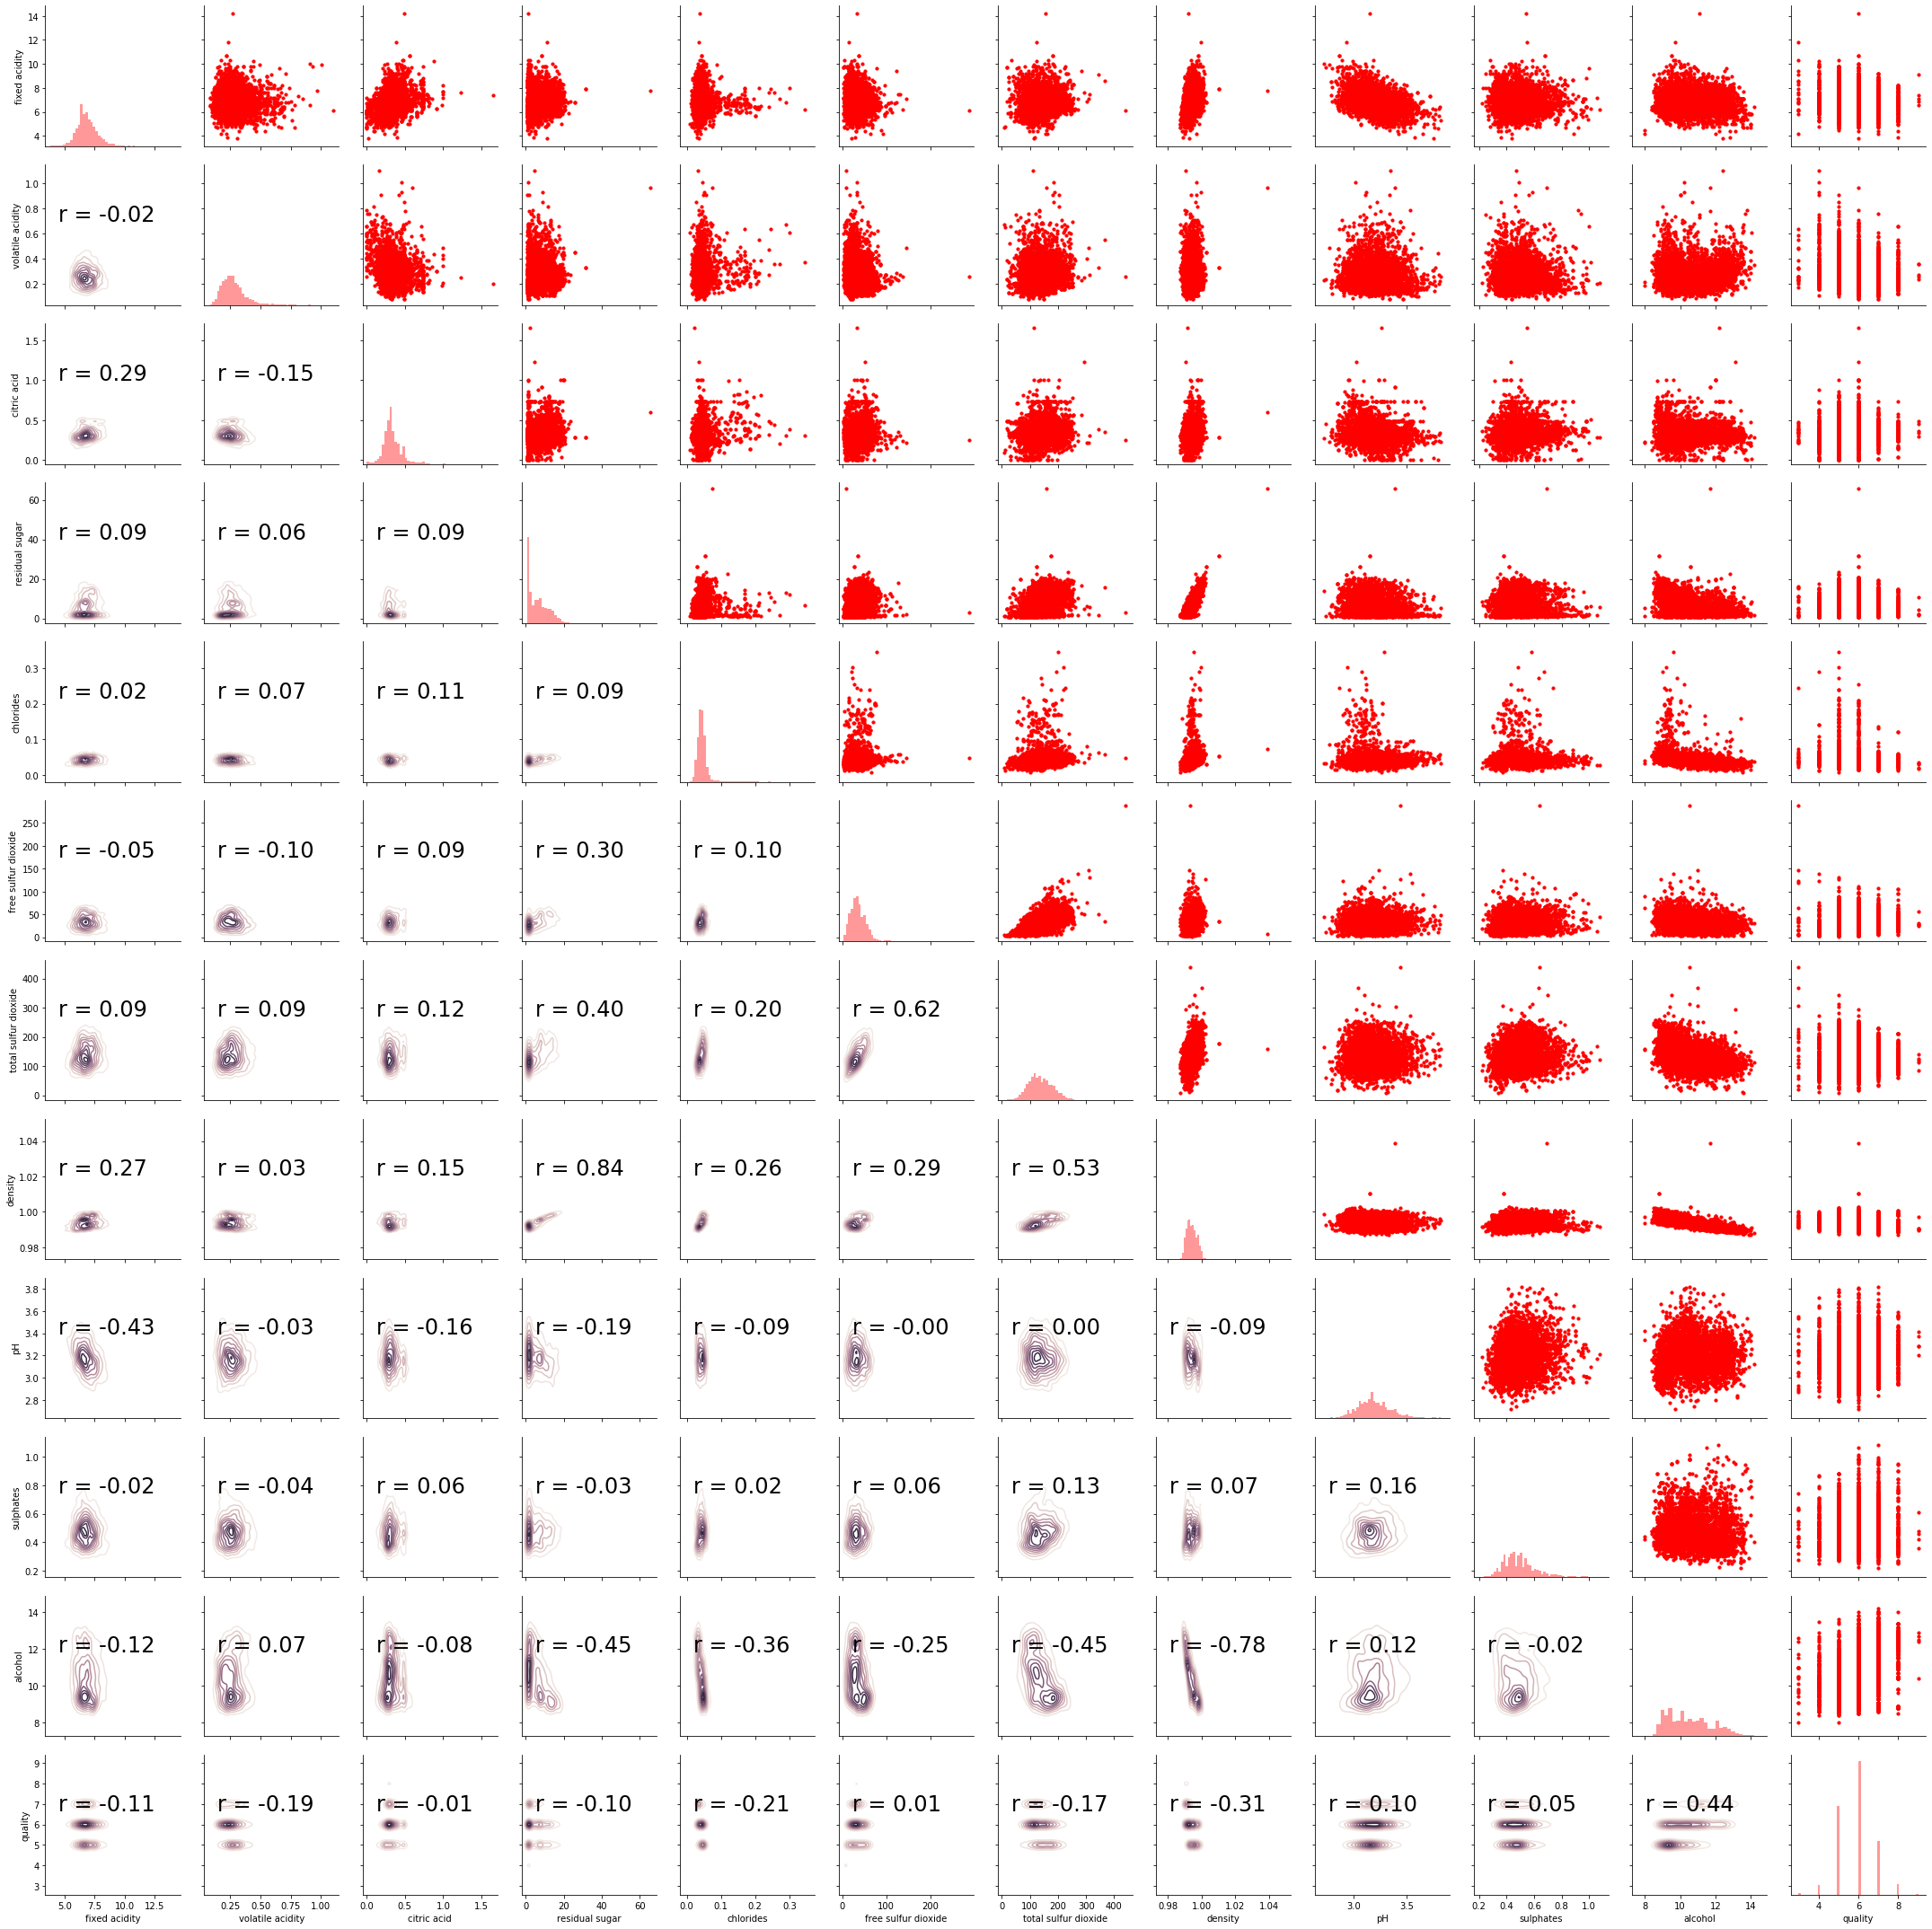

In [9]:
import warnings
warnings.filterwarnings('ignore')


# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

#See https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

In [10]:
df = df.drop(labels=['citric acid', 'free sulfur dioxide'], axis = 1) 
# dropped those with low correlation

In [11]:
# partition function
y = df['quality'] # 1D targer vector
X = df.drop(labels='quality', axis=1)

def partition(X, y, t):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, (1-t)*100)
    X_train = np.array(X[split])
    y_train = np.array(y[split])
    X_test =  np.array(X[~split])
    y_test = np.array(y[~split])
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = partition(X, y, t=0.2)

In [12]:
# scaling/standarize dataset to guarantee convergence
# b. Scale/Standarize
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)
scale = np.frompyfunc(lambda x, mean, std: (x - mean) / (std), 3, 1)

X_train_scaled = scale(X_train, mean, std).astype(float)
X_test_scaled = scale(X_test, mean, std).astype(float)

### Part C.  Model Evaluation

In [13]:
import random
def sFold(folds, data, labels, model, *model_args, error_function): 
    
    all_data = np.c_[data, labels]
    # i. helper function which creates data_splits
    data_splits = list()
    data_copy = list(all_data)
    fold_size = int(len(data_copy) / folds)
    
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(data_copy))
            fold.append(data_copy.pop(index))
        data_splits.append(fold)

    # ii. for each partition, make model, remove one fold, make prediction, store prediction
    model = model
    scores = list()
    expected = list()
    predicted = list()
    
    for ds in data_splits:
        train_set = list(data_splits)
        train_set = [ x for x in train_set if not (x==np.array(ds)).all()]
        train_set = sum(train_set,[])
        test_set = list()
        for row in ds:
            row_copy = list(row)
            test_set.append(row_copy)
        
        y_train = [row[-1] for row in train_set]
        train_set = np.asarray([train[:-1] for train in train_set])
        
        model.fit(X = train_set, Y = y_train)
        
        actual = [row[-1] for row in test_set]
        test_set = np.asarray([test[:-1] for test in test_set])
        
        # Make prediction in current partition
        estimate  = model.predict(test_set, *model_args)
        acc = error_function(actual, estimate)
        
        scores.append(acc)
        expected.append(actual)
        predicted.append(estimate)
        
    average_scores = sum(scores)/len(scores)
    final_dict = {'expected' : expected, 'predicted' : predicted, 'average error' : average_scores}
    
    return final_dict

#### 10. Model selection via Hyperparameter tuning

In [14]:
# Set the the ranges
lamb = [1.0, 0, 0.1, 0.01, 0.001, 0.0001]
learning_rate = [0.1, 0.01, 0.001]
regularizer = ['l1', 'l2'] 

performance_list = list() # List to store dictionaries of each
for l in lamb:
    for r in learning_rate:
        for g in regularizer:
            print(str(l) + str(r) + g)
            # Run the sFold for each one
            evaluate = sFold(folds = 4, data = X_train_scaled, labels = y_train, 
                            model = Linear_Regression(epochs = 100, learning_rate = r, lamb = l, regularizer = g),
                            error_function = mse)
            print(evaluate['average error'])
            performance_list.append(evaluate)

1.00.1l1
0.5717930597381893
1.00.1l2
nan
1.00.01l1
1.2044531028496193
1.00.01l2
inf
1.00.001l1
23.861912338280277
1.00.001l2
2.7510245600448977e+244
1.00.001l1
23.866375664316116
1.00.001l2
1.0069263926492839e+243
00.1l1
0.5711100344644781
00.1l2
nan
00.01l1
1.2081160232055013
00.01l2
inf
00.001l1
23.849984226219682
00.001l2
7.044604640945969e+243
00.001l1
23.860368902723422
00.001l2
8.824979808539627e+243
0.10.1l1
0.572503286403202
0.10.1l2
nan
0.10.01l1
1.2082361116482443
0.10.01l2
inf
0.10.001l1
23.85645840507457
0.10.001l2
6.6243765097694255e+242
0.10.001l1
23.86899116938087
0.10.001l2
1.7162302178297333e+243
0.010.1l1
0.5719908489636678
0.010.1l2
nan
0.010.01l1
1.2077018465949139
0.010.01l2
inf
0.010.001l1
23.861521038434457
0.010.001l2
6.367014807729989e+242
0.010.001l1
23.862529200599855
0.010.001l2
1.059788485266191e+243
0.0010.1l1
0.5725227096106831
0.0010.1l2
nan
0.0010.01l1
1.2052617018583445
0.0010.01l2
inf
0.0010.001l1
23.854916069799888
0.0010.001l2
1.0878038778077006e+24

#### 11. Evaluate your model on the test data and report the mean squared error. 

In [15]:
# Run final model with best f1 score
# Create KNN Object
model_final = Linear_Regression(epochs = 1000, learning_rate = 0.1, lamb = 0.001, regularizer = 'l1')

# Fit and Predict
model_final.fit(X = X_train_scaled, Y = y_train)
preds = model_final.predict(X = X_test_scaled)

# MSE
mse(preds, y_test)

0.5820036465995846

#### 12. Using the best model plot the learning curve.

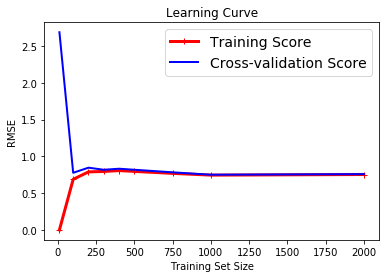

In [16]:
learning_curve(model = Linear_Regression(epochs = 1000, learning_rate = 0.1, lamb = 0.001, regularizer = 'l1'), X = X_train_scaled,Y = y_train, cv= 4,train_sizes=[10,100,200,300,400,500,750,1000,2000])

#### 13. Determine the best model hyperparameter values for the training data matrix with polynomial degree 3 and plot the learning curve.

In [17]:
X_train_pol = polynomialFeatures(X_train, 3)
X_test_pol = polynomialFeatures(X_test, 3)

# b. Scale/Standarize
mean = np.mean(X_train_pol, axis = 0)
std = np.std(X_train_pol, axis = 0)
scale = np.frompyfunc(lambda x, mean, std: (x - mean) / (std), 3, 1)

X_train_pol_scaled = scale(X_train_pol, mean, std).astype(float)
X_test_pol_scaled = scale(X_test_pol, mean, std).astype(float)

In [18]:
# Set the the ranges
lamb = [1.0, 0, 0.1, 0.01, 0.001, 0.0001]
learning_rate = [0.1, 0.01, 0.001]
regularizer = ['l1', 'l2'] 

performance_list = list() # List to store dictionaries of each
for l in lamb:
    for r in learning_rate:
        for g in regularizer:
            print(str(l) + str(r) + g)
            # Run the sFold for each one
            evaluate = sFold(folds = 4, data = X_train_pol_scaled, labels = y_train, 
                            model = Linear_Regression(epochs = 100, learning_rate = r, lamb = l, regularizer = g),
                            error_function = mse)
            print(evaluate['average error'])
            performance_list.append(evaluate)

1.00.1l1
inf
1.00.1l2
nan
1.00.01l1
3.157957028931628e+144
1.00.01l2
nan
1.00.001l1
23.91007971663472
1.00.001l2
nan
1.00.001l1
23.84967473960853
1.00.001l2
nan
00.1l1
inf
00.1l2
nan
00.01l1
1.3505294071536593e+144
00.01l2
nan
00.001l1
23.903719536355403
00.001l2
nan
00.001l1
23.892567486891387
00.001l2
nan
0.10.1l1
inf
0.10.1l2
nan
0.10.01l1
1.7421239921457519e+143
0.10.01l2
nan
0.10.001l1
23.935421428478982
0.10.001l2
nan
0.10.001l1
24.006626431039944
0.10.001l2
nan
0.010.1l1
inf
0.010.1l2
nan
0.010.01l1
2.8480702840390806e+145
0.010.01l2
nan
0.010.001l1
23.88633744624679
0.010.001l2
nan
0.010.001l1
23.910607926775704
0.010.001l2
nan
0.0010.1l1
inf
0.0010.1l2
nan
0.0010.01l1
2.7617226421600614e+145
0.0010.01l2
nan
0.0010.001l1
23.89710440696115
0.0010.001l2
nan
0.0010.001l1
24.017600849818677
0.0010.001l2
nan
0.00010.1l1
inf
0.00010.1l2
nan
0.00010.01l1
1.659098876800941e+144
0.00010.01l2
nan
0.00010.001l1
23.90895601770652
0.00010.001l2
nan
0.00010.001l1
23.843651124407018
0.00010.0

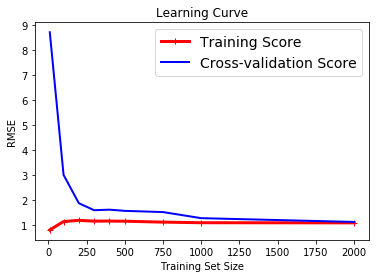

In [19]:
# using best model plot learning curve for polynomial
learning_curve(model = Linear_Regression(epochs = 1000, learning_rate = 0.001, lamb = 1, regularizer = 'l1'), X = X_train_pol_scaled,Y = y_train, cv= 4, train_sizes=[10,100,200,300,400,500,750,1000,2000])